In [1]:
import pandas as pd
import numpy as np
import tabulate
import matplotlib.pyplot as plt
import re
import sklearn.preprocessing
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics as skm
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

pd.options.display.max_columns = None

In [2]:
# load the data

pitches = pd.read_csv("data/pitches.csv")
atbats = pd.read_csv("data/atbats.csv")
ejections = pd.read_csv("data/ejections.csv")
games = pd.read_csv("data/games.csv")
player_names = pd.read_csv("data/player_names.csv")

In [3]:
# decode labels for outcomes and pitch types

# outcome codes
outcome_code = {
    'outcome_code' : ['B', '*B', 'S', 'C', 
                      'F', 'T', 'L', 'I', 
                      'W', 'M', 'P', 
                      'Q','R', 'X', 
                      'D', 'E', 'H',
                      'V', 'Z'],
    'outcome_description' : ['Ball', 'Ball in Dirt', 'Swinging Strike', 'Called Strike',
                            'Foul', 'Foul Tip', 'Foul Bunt', 'Intentional Ball',
                            'Swinging Strike (Blocked)', 'Missed Bunt', 'Pitchout',
                            'Swinging Pitchout', 'Foul Pitchout', 'In Play, Out(s)', 
                            'In Play, No Outs', 'In Play, Runs', 'Hit by pitch',
                            'V', 'Z']
}
outcome_code = pd.DataFrame.from_dict(outcome_code)

# pitch type codes
pitch_code = {
    'pitch_code' : ['CH', 'CU', 'EP', 'FC', 
                      'FF', 'FO', 'FS', 'FT', 
                      'IN', 'KC', 'KN', 
                      'PO','SC', 'SI', 
                      'SL', 'UN', 'FA', 'AB'],
    'pitch_description' : ['Changeup', 'Curveball', 'Eephus', 'Cutter',
                            'Four-seam Fastball', 'Pitchout', 'Splitter', 'Two-seam Fastball',
                            'Intentionall ball', 'Knuckle curve', 'Knuckleball',
                            'Pitchout', 'Screwball', 'Sinker', 
                            'Slider', 'Unknown', 'FA', 'AB']
}
pitch_code = pd.DataFrame.from_dict(pitch_code)

In [4]:
# pitch outcomes, probabilities
pitch_outcome = pd.DataFrame(pitches['code'].value_counts())
pitch_outcome.columns = ['outcome_count']

outcome_df = pd.merge(pitch_outcome, outcome_code, how='left',
        left_index=True, right_on = 'outcome_code')
outcome_df['outcome_prob']= outcome_df['outcome_count']/outcome_df['outcome_count'].sum()
outcome_df

,outcome_count,outcome_code,outcome_description,outcome_prob
0,956646,B,Ball,3.343239e-01
4,496512,F,Foul,1.735185e-01
3,480903,C,Called Strike,1.680636e-01
13,330875,X,"In Play, Out(s)",1.156325e-01
2,271330,S,Swinging Strike,9.482305e-02
14,117123,D,"In Play, No Outs",4.093156e-02
1,65675,*B,Ball in Dirt,2.295177e-02
15,64166,E,"In Play, Runs",2.242441e-02
5,23947,T,Foul Tip,8.368878e-03
8,23137,W,Swinging Strike (Blocked),8.085803e-03


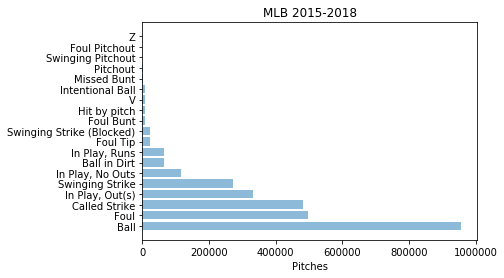

In [5]:
# bar chart of pitch outcomes
objects = outcome_df.outcome_description
y_pos = np.arange(len(outcome_df.outcome_description))
performance = outcome_df.outcome_count

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Pitches')
plt.title('MLB 2015-2018')

plt.show()

In [6]:
# pitch types, probabilities
pitch_type = pd.DataFrame(pitches['pitch_type'].value_counts())
pitch_type.columns = ['pitch_type_count']

pitch_df = pd.merge(pitch_type, pitch_code, how='left',
        left_index=True, right_on = 'pitch_code')
pitch_df['pitch_prob']= pitch_df['pitch_type_count']/pitch_df['pitch_type_count'].sum()
pitch_df


,pitch_type_count,pitch_code,pitch_description,pitch_prob
4,1014877,FF,Four-seam Fastball,0.355727
14,450578,SL,Slider,0.157933
7,337983,FT,Two-seam Fastball,0.118467
0,292789,CH,Changeup,0.102626
13,242504,SI,Sinker,0.085001
1,234391,CU,Curveball,0.082157
3,149756,FC,Cutter,0.052491
9,66484,KC,Knuckle curve,0.023303
6,43705,FS,Splitter,0.015319
10,11260,KN,Knuckleball,0.003947


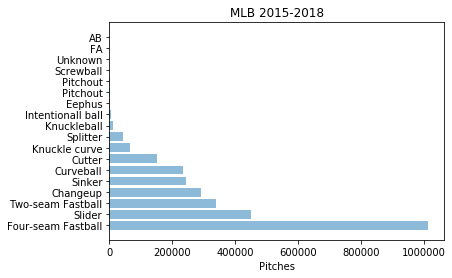

In [7]:
# bar chart of pitch types
objects = pitch_df.pitch_description
y_pos = np.arange(len(pitch_df.pitch_description))
performance = pitch_df.pitch_type_count

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Pitches')
plt.title('MLB 2015-2018')

plt.show()

In [8]:
# join all the data into all_df
all_df = pd.merge(pitches, atbats, how='left',
        left_on = 'ab_id', right_on = 'ab_id')

pitcher_df = player_names
pitcher_df.columns = ['pitcher_id', 'pitcher_first_name', 'pitcher_last_name']

all_df = pd.merge(all_df, pitcher_df, how='left',
        left_on = 'pitcher_id', right_on = 'pitcher_id')

batter_df = player_names
batter_df.columns = ['batter_id', 'batter_first_name', 'batter_last_name']

all_df = pd.merge(all_df, batter_df, how='left',
        left_on = 'batter_id', right_on = 'batter_id')

all_df = pd.merge(all_df, games, how='left',
        left_on = 'g_id', right_on = 'g_id')

all_df = pd.merge(all_df, pitch_code, how='left',
        left_on = 'pitch_type', right_on = 'pitch_code')

all_df = pd.merge(all_df, outcome_code, how='left',
        left_on = 'code', right_on = 'outcome_code')

all_df.head(25)


#all_df.shape[0]

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,type,pitch_type,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,pitcher_first_name,pitcher_last_name,batter_first_name,batter_last_name,attendance,away_final_score,away_team,date,elapsed_time,home_final_score,home_team,start_time,umpire_1B,umpire_2B,umpire_3B,umpire_HP,venue_name,weather,wind,delay,pitch_code,pitch_description,outcome_code,outcome_description
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,34.685,-11.960,1.72,3.56,2.000,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,4.16,10.93,55.0,3.0,C,S,FF,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,Jon,Lester,Matt,Carpenter,35055,3,sln,2015-04-05,184,0,chn,7:17 PM,Mark Wegner,Marty Foster,Mike Muchlinski,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,FF,Four-seam Fastball,C,Called Strike
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,34.225,-10.085,1.72,3.56,2.000,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,6.57,12.00,31.0,5.0,S,S,FF,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,Jon,Lester,Matt,Carpenter,35055,3,sln,2015-04-05,184,0,chn,7:17 PM,Mark Wegner,Marty Foster,Mike Muchlinski,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,FF,Four-seam Fastball,S,Swinging Strike
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,35.276,-11.560,1.72,3.56,2.000,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,7.61,10.88,49.0,1.0,F,S,FF,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,Jon,Lester,Matt,Carpenter,35055,3,sln,2015-04-05,184,0,chn,7:17 PM,Mark Wegner,Marty Foster,Mike Muchlinski,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,FF,Four-seam Fastball,F,Foul
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,28.354,-20.540,1.74,3.35,2.000,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,1.17,6.45,41.0,13.0,B,B,FF,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,Jon,Lester,Matt,Carpenter,35055,3,sln,2015-04-05,184,0,chn,7:17 PM,Mark Wegner,Marty Foster,Mike Muchlinski,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,FF,Four-seam Fastball,B,Ball
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,21.774,-34.111,1.72,3.56,2.000,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,-8.43,-1.65,18.0,13.0,B,B,CU,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,Jon,Lester,Matt,Carpenter,35055,3,sln,2015-04-05,184,0,chn,7:17 PM,Mark Wegner,Marty Foster,Mike Muchlinski,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,CU,Curveball,B,Ball
5,0.627,2.397,92.9,84.8,2743.856,148.110,-45.7,3.7,23.7,13.590,32.274,-10.333,1.72,3.56,2.000,-6.943,-136.012,-5.738,118.004772,2.273,164.467012,50.0,5.264,7.32,11.72,42.0,6.0,X,X,FF,8,0.0,2.015000e+09,2.0,2.0,0.0,6.0,0.0,0.0,0.0,572761,Groundout,201500001,1,1,0,L,452657,L,True,Jon,Lester,Matt,Carpenter,35055,3,sln,2015-04-05,184,0,chn,7:17 PM,Mark Wegner,Marty Foster,Mike Muchlinski,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,FF,Four-seam Fastball,X,"In Play, Out(s)"
6,-1.088,1.610,93.3,85.3,2848.535,147.044,-46.3,3.6,23.7,14.549,31.469,-9.734,1.59,3.45,2.000,-11.032,-136.208,-7.762,141.430000,2.013,205.810000,50.0,5.179,7.79,11.97,80.0,13.0,B,B,FF,12,0.0,2.015000e+09,0.0,0.0,1.0,1.0,0.0,0.0,0.0,518792,Double,201500001,1,1,0,L,452657,L,True,Jon,Lester,Jason,Heyward,35055,3,sln,2015-04-05,184,0,chn,7:17 PM,Mark Wegner,Marty Foster,Mike Muchlinski,Mike Winters,Wrigley Field,"44 degrees, clear","7

In [9]:
# pick out the columns that are known before a pitch takes place

pred_df = all_df[['pitch_code', 'pitch_description', 'b_score', 'b_count', 's_count',
                 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'batter_id', 'inning', 'o',
                 'p_score', 'p_throws', 'stand', 'top', 'batter_id', 'pitcher_id',
                 'attendance', 'away_team', 'home_team', 'umpire_HP',
                 'venue_name', 'weather', 'wind', 'delay']]
pred_df.head(5)

,pitch_code,pitch_description,b_score,b_count,s_count,pitch_num,on_1b,on_2b,on_3b,batter_id,inning,o,p_score,p_throws,stand,top,batter_id,pitcher_id,attendance,away_team,home_team,umpire_HP,venue_name,weather,wind,delay
0,FF,Four-seam Fastball,0.0,0.0,0.0,1.0,0.0,0.0,0.0,572761,1,1,0,L,L,True,572761,452657,35055,sln,chn,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0
1,FF,Four-seam Fastball,0.0,0.0,1.0,2.0,0.0,0.0,0.0,572761,1,1,0,L,L,True,572761,452657,35055,sln,chn,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0
2,FF,Four-seam Fastball,0.0,0.0,2.0,3.0,0.0,0.0,0.0,572761,1,1,0,L,L,True,572761,452657,35055,sln,chn,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0
3,FF,Four-seam Fastball,0.0,0.0,2.0,4.0,0.0,0.0,0.0,572761,1,1,0,L,L,True,572761,452657,35055,sln,chn,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0
4,CU,Curveball,0.0,1.0,2.0,5.0,0.0,0.0,0.0,572761,1,1,0,L,L,True,572761,452657,35055,sln,chn,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0


In [10]:
pitches.shape[0]

2867154

In [11]:
# extract weather conditions
pred_df['temp'] = pred_df['weather'].str.extract(r'(\d+)') # temperature
pred_df['temp'] = pd.to_numeric(pred_df['temp'])
pred_df['weather_cond'] = pred_df['weather'].str.extract(r'([^,]*$)') # weather condition
pred_df['wind_mph'] = pred_df['wind'].str.extract(r'(\d+)') # wind speed
pred_df['wind_mph'] = pd.to_numeric(pred_df['wind_mph'])
pred_df['wind_dir'] = pred_df['wind'].str.extract(r'([^,]*$)') # wind direction

pred_df.head(5)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,pitch_code,pitch_description,b_score,b_count,s_count,pitch_num,on_1b,on_2b,on_3b,batter_id,inning,o,p_score,p_throws,stand,top,batter_id,pitcher_id,attendance,away_team,home_team,umpire_HP,venue_name,weather,wind,delay,temp,weather_cond,wind_mph,wind_dir
0,FF,Four-seam Fastball,0.0,0.0,0.0,1.0,0.0,0.0,0.0,572761,1,1,0,L,L,True,572761,452657,35055,sln,chn,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,44,clear,7,In from CF
1,FF,Four-seam Fastball,0.0,0.0,1.0,2.0,0.0,0.0,0.0,572761,1,1,0,L,L,True,572761,452657,35055,sln,chn,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,44,clear,7,In from CF
2,FF,Four-seam Fastball,0.0,0.0,2.0,3.0,0.0,0.0,0.0,572761,1,1,0,L,L,True,572761,452657,35055,sln,chn,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,44,clear,7,In from CF
3,FF,Four-seam Fastball,0.0,0.0,2.0,4.0,0.0,0.0,0.0,572761,1,1,0,L,L,True,572761,452657,35055,sln,chn,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,44,clear,7,In from CF
4,CU,Curveball,0.0,1.0,2.0,5.0,0.0,0.0,0.0,572761,1,1,0,L,L,True,572761,452657,35055,sln,chn,Mike Winters,Wrigley Field,"44 degrees, clear","7 mph, In from CF",0,44,clear,7,In from CF


In [12]:
# one-hot encode all the dummy variables

pitch_num_dummy = pd.get_dummies(pred_df['pitch_num'], prefix='pitch_num')
p_throws_dummy = pd.get_dummies(pred_df['p_throws'], prefix='p_throws')
stand_dummy = pd.get_dummies(pred_df['stand'], prefix='stand')
away_team_dummy = pd.get_dummies(pred_df['away_team'], prefix='away_team')
home_team_dummy = pd.get_dummies(pred_df['home_team'], prefix='home_team')
umpire_HP_dummy = pd.get_dummies(pred_df['umpire_HP'], prefix='umpire_HP')
venue_name_dummy = pd.get_dummies(pred_df['venue_name'], prefix='venue_name')
weather_cond_dummy = pd.get_dummies(pred_df['weather_cond'], prefix='weather_cond')
wind_dir_dummy = pd.get_dummies(pred_df['wind_dir'], prefix='wind_dir')

encoded_df = pd.concat([pred_df, pitch_num_dummy, p_throws_dummy, stand_dummy, away_team_dummy,
           home_team_dummy, umpire_HP_dummy, venue_name_dummy, weather_cond_dummy,
           wind_dir_dummy], axis=1)
encoded_df.head(5)

,pitch_code,pitch_description,b_score,b_count,s_count,pitch_num,on_1b,on_2b,on_3b,batter_id,inning,o,p_score,p_throws,stand,top,batter_id,pitcher_id,attendance,away_team,home_team,umpire_HP,venue_name,weather,wind,delay,temp,weather_cond,wind_mph,wind_dir,pitch_num_1.0,pitch_num_2.0,pitch_num_3.0,pitch_num_4.0,pitch_num_5.0,pitch_num_6.0,pitch_num_7.0,pitch_num_8.0,pitch_num_9.0,pitch_num_10.0,pitch_num_11.0,pitch_num_12.0,pitch_num_13.0,pitch_num_14.0,pitch_num_15.0,pitch_num_16.0,pitch_num_17.0,pitch_num_18.0,pitch_num_19.0,pitch_num_20.0,pitch_num_21.0,p_throws_L,p_throws_R,stand_L,stand_R,away_team_ana,away_team_ari,away_team_atl,away_team_bal,away_team_bos,away_team_cha,away_team_chn,away_team_cin,away_team_cle,away_team_col,away_team_det,away_team_hou,away_team_kca,away_team_lan,away_team_mia,away_team_mil,away_team_min,away_team_nya,away_team_nyn,away_team_oak,away_team_phi,away_team_pit,away_team_sdn,away_team_sea,away_team_sfn,away_team_sln,away_team_tba,away_team_tex,away_team_tor,away_team_was,home_team_ana,home_team_ari,home_team_atl,home_team_bal,home_team_bos,home_team_cha,home_team_chn,home_team_cin,home_team_cle,home_team_col,home_team_det,home_team_hou,home_team_kca,home_team_lan,home_team_mia,home_team_mil,home_team_min,home_team_nya,home_team_nyn,home_team_oak,home_team_phi,home_team_pit,home_team_sdn,home_team_sea,home_team_sfn,home_team_sln,home_team_tba,home_team_tex,home_team_tor,home_team_was,umpire_HP_Adam Hamari,umpire_HP_Adrian Johnson,umpire_HP_Alan Porter,umpire_HP_Alfonso Marquez,umpire_HP_Andy Fletcher,umpire_HP_Angel Hernandez,umpire_HP_Anthony Johnson,umpire_HP_Ben May,umpire_HP_Bill Miller,umpire_HP_Bill Welke,umpire_HP_Bob Davidson,umpire_HP_Brian Gorman,umpire_HP_Brian Knight,umpire_HP_Brian O'Nora,umpire_HP_Bruce Dreckman,umpire_HP_CB Bucknor,umpire_HP_Carlos Torres,umpire_HP_Chad Fairchild,umpire_HP_Chad Whitson,umpire_HP_Chris Conroy,umpire_HP_Chris Guccione,umpire_HP_Chris Segal,umpire_HP_Clint Fagan,umpire_HP_Cory Blaser,umpire_HP_D.J. Reyburn,umpire_HP_Dale Scott,umpire_HP_Dan Bellino,umpire_HP_Dan Iassogna,umpire_HP_Dana DeMuth,umpire_HP_David Rackley,umpire_HP_Doug Eddings,umpire_HP_Ed Hickox,umpire_HP_Eric Cooper,umpire_HP_Fieldin Culbreth,umpire_HP_Gabe Morales,umpire_HP_Gary Cederstrom,umpire_HP_Gerry Davis,umpire_HP_Greg Gibson,umpire_HP_Hunter Wendelstedt,umpire_HP_James Hoye,umpire_HP_Jansen Visconti,umpire_HP_Jeff Kellogg,umpire_HP_Jeff Nelson,umpire_HP_Jeremie Rehak,umpire_HP_Jerry Layne,umpire_HP_Jerry Meals,umpire_HP_Jim Joyce,umpire_HP_Jim Reynolds,umpire_HP_Jim Wolf,umpire_HP_Joe West,umpire_HP_John Hirschbeck,umpire_HP_John Libka,umpire_HP_John Tumpane,umpire_HP_Jordan Baker,umpire_HP_Kerwin Danley,umpire_HP_Lance Barksdale,umpire_HP_Lance Barrett,umpire_HP_Larry Vanover,umpire_HP_Laz Diaz,umpire_HP_Manny Gonzalez,umpire_HP_Marcus Pattillo,umpire_HP_Mark Carlson,umpire_HP_Mark Ripperger,umpire_HP_Mark Wegner,umpire_HP_Marty Foster,umpire_HP_Marvin Hudson,umpire_HP_Mike DiMuro,umpire_HP_Mike Estabrook,umpire_HP_Mike Everitt,umpire_HP_Mike Muchlinski,umpire_HP_Mike Winters,umpire_HP_Nic Lentz,umpire_HP_Nick Mahrley,umpire_HP_Pat Hoberg,umpire_HP_Paul Emmel,umpire_HP_Paul Nauert,umpire_HP_Paul Schrieber,umpire_HP_Phil Cuzzi,umpire_HP_Quinn Wolcott,umpire_HP_Ramon De Jesus,umpire_HP_Rob Drake,umpire_HP_Roberto Ortiz,umpire_HP_Ron Kulpa,umpire_HP_Ryan Additon,umpire_HP_Ryan Blakney,umpire_HP_Sam Holbrook,umpire_HP_Scott Barry,umpire_HP_Sean Barber,umpire_HP_Shane Livensparger,umpire_HP_Stu Scheurwater,umpire_HP_Ted Barrett,umpire_HP_Tim Timmons,umpire_HP_Tim Welke,umpire_HP_Toby Basner,umpire_HP_Todd Tichenor,umpire_HP_Tom Hallion,umpire_HP_Tom Woodring,umpire_HP_Tony Randazzo,umpire_HP_Tripp Gibson III,umpire_HP_Vic Carapazza,umpire_HP_Will Little,venue_name_AT&T Park,venue_name_Angel Stadium,venue_name_Angel Stadium of Anaheim,venue_name_BB&T Ballpark,venue_name_Busch Stadium,venue_name_Chase Field,venue_name_Citi Field,venue_name_Citizens Bank Park,venue_name_Comerica Park

In [13]:
# factorize the dependent variable pitch code

factor = pd.factorize(encoded_df['pitch_code'])
encoded_df['pitch_code_num'] = factor[0]
pitch_code_def = factor[1]
print(pitch_code_def)

Index(['FF', 'CU', 'FC', 'SI', 'CH', 'FT', 'IN', 'SL', 'KC', 'EP', 'FS', 'FO',
       'PO', 'KN', 'UN', 'SC', 'FA', 'AB'],
      dtype='object')


In [14]:
# remove categorical variables

encoded_df = encoded_df.drop(['pitch_code','pitch_description', 'pitch_num', 'p_throws', 'stand',
                             'away_team', 'home_team', 'umpire_HP', 'venue_name', 'weather_cond',
                             'wind_dir', 'batter_id', 'pitcher_id', 'wind', 'weather'], axis=1)

In [15]:
# specify subset of records to use
encoded_df = encoded_df[ :1000000]

In [16]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Columns: 262 entries, b_score to pitch_code_num
dtypes: bool(1), float64(6), int64(8), uint8(247)
memory usage: 351.0 MB


In [17]:
encoded_df.dropna(inplace=True)

In [18]:
encoded_df.dtypes

b_score                                          float64
b_count                                          float64
s_count                                          float64
on_1b                                            float64
on_2b                                            float64
on_3b                                            float64
inning                                             int64
o                                                  int64
p_score                                            int64
top                                                 bool
attendance                                         int64
delay                                              int64
temp                                               int64
wind_mph                                           int64
pitch_num_1.0                                      uint8
pitch_num_2.0                                      uint8
pitch_num_3.0                                      uint8
pitch_num_4.0                  

In [19]:
X = sklearn.preprocessing.scale(encoded_df.iloc[ : , :-1]) # use all but the last column
y = encoded_df['pitch_code_num'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
# logistic regression - this fails to converge after many hours

# mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='saga').fit(X_train, y_train)

# print('Multinomial Logistic regression Train Accuracy')
# metrics.accuracy_score(y_train, mul_lr.predict(X_train))

# print('Multinomial Logistic regression Test Accuracy')
# metrics.accuracy_score(y_test, mul_lr.predict(X_test))

In [ ]:
# random forest model
# https://www.codementor.io/agarrahul01/multiclass-classification-using-random-forest-on-scikit-learn-library-hkk4lwawu

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results

y_pred = classifier.predict(X_test)
y_pred.size

# reverse factorization
reversefactor = dict(zip(range(18),pitch_code_def))
y_test = np.vectorize(reversefactor.get)(y_test)

y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Pitch'], colnames=['Predicted Pitch']))

In [ ]:
df_x_train = pd.DataFrame(X_train)

feature_importances = pd.DataFrame(classifier.feature_importances_,
                                   index = df_x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

train_col_df = pd.DataFrame(encoded_df.columns)
train_col_df

fi = pd.merge(feature_importances, train_col_df, how='left',
        left_index = True, right_index = True)
fi.iloc[:20]
#fi.to_csv('importance.csv')

In [ ]:
print(skm.classification_report(y_test,y_pred))